### Convolutional Neural Network Model ###
#### Brain Tumor Identification ####

Import Libraries

In [1]:
# Brain Tumor Identifier V2 
# Convolutional Neural Networks
# Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

Setting up the GPU

In [2]:
#GPU
# Avoids OOM error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')  # Finds all the GPUs on our machine
for gpu in gpus:    # Limiting the memory growth for all GPUs at a min or what is required
    tf.config.experimental.set_memory_growth(gpu,True)

print('Num GPUs Available: ',len(gpus))

Num GPUs Available:  1


Import and Split Data

In [6]:
# Import the data
import random
import glob
import os # os is typically used to navigate file structures
import shutil
diagnosis = ['yes','no']
os.chdir('C:\\Users\...........\Image Classification\Brain Tumor\data') # <----- Modify this
if os.path.isdir('train/yes') is False:
    for set in ['train','valid','test']:
        os.makedirs(set+'/'+diagnosis[0])
        os.makedirs(set+'/'+diagnosis[1])

    for type in random.sample(glob.glob('y*'),1000):
        shutil.move(type,'train/yes')
    for type in random.sample(glob.glob('n*'),1000):
        shutil.move(type,'train/no')
    for type in random.sample(glob.glob('y*'),300):
        shutil.move(type,'valid/yes')
    for type in random.sample(glob.glob('n*'),300):
        shutil.move(type,'valid/no')
    for type in random.sample(glob.glob('y*'),200):
        shutil.move(type,'test/yes')
    for type in random.sample(glob.glob('n*'),200):
        shutil.move(type,'test/no')
else:
    print('The data has already been processed')
os.chdir('../../')

The data has already been processed


In [7]:
# Assign paths
train_path = 'Brain Tumor/data/train'
valid_path = 'Brain Tumor/data/valid'
test_path = 'Brain Tumor/data/test'
# for some reason \ slashes in path (Brain Tumor\data\valid) will not give any results for images
# ie. 0 images in 2 classes

In [8]:
# Generate batches of data
# Used grayscale
train_batches = ImageDataGenerator()\
    .flow_from_directory(directory=train_path,target_size=(224,224),classes=['yes','no'],batch_size=10,color_mode='grayscale')

valid_batches = ImageDataGenerator()\
    .flow_from_directory(directory=valid_path,target_size=(224,224),classes=['yes','no'],batch_size=10, color_mode='grayscale')

test_batches = ImageDataGenerator()\
    .flow_from_directory(directory=test_path,target_size=(224,224),classes=['yes','no'],batch_size=10,color_mode='grayscale',shuffle=False)
    # We want to access unshuffled labels of test set to observe results in a confusion matrix

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [9]:
# This process is done to debug and make sure we got the right values
assert train_batches.n == 2000
assert valid_batches.n == 600
assert test_batches.n == 400
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

Visualize Data

In [10]:
imgs,labels = next(train_batches)

In [11]:
# Functions plots images in a grid with 1 row and 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

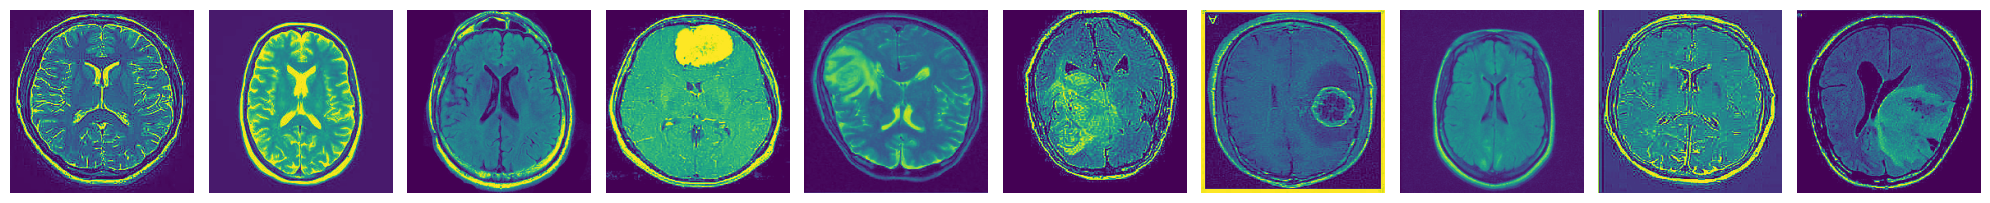

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [12]:
plotImages(imgs)
print(labels)

Create the CNN Model

In [13]:
# Build and train the model
# For grayscale 224,224,1 were used
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(224,224,1)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    Flatten(),
    Dense(units=2,activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 802816)            0         
                                                                 
 dense (Dense)               (None, 2)                 1605634   
                                                                 
Total params: 1,624,450
Trainable params: 1,624,450
Non-trainable params: 0
______________________________________________

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
# Train the model
# Note: No y-value in this fit because data image generator already has the labels
cnn = model.fit(x=train_batches,validation_data=valid_batches,epochs=20,verbose=2)

Epoch 1/20
200/200 - 247s - loss: 13.1981 - accuracy: 0.8000 - val_loss: 0.6821 - val_accuracy: 0.9433 - 247s/epoch - 1s/step
Epoch 2/20
200/200 - 29s - loss: 0.2888 - accuracy: 0.9710 - val_loss: 0.4120 - val_accuracy: 0.9583 - 29s/epoch - 147ms/step
Epoch 3/20
200/200 - 14s - loss: 0.0704 - accuracy: 0.9895 - val_loss: 0.6690 - val_accuracy: 0.9517 - 14s/epoch - 72ms/step
Epoch 4/20
200/200 - 14s - loss: 0.0966 - accuracy: 0.9895 - val_loss: 0.5662 - val_accuracy: 0.9433 - 14s/epoch - 68ms/step
Epoch 5/20
200/200 - 14s - loss: 0.0619 - accuracy: 0.9895 - val_loss: 0.4269 - val_accuracy: 0.9567 - 14s/epoch - 69ms/step
Epoch 6/20
200/200 - 14s - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.4567 - val_accuracy: 0.9700 - 14s/epoch - 68ms/step
Epoch 7/20
200/200 - 13s - loss: 0.0224 - accuracy: 0.9960 - val_loss: 0.4360 - val_accuracy: 0.9650 - 13s/epoch - 67ms/step
Epoch 8/20
200/200 - 13s - loss: 1.6268e-05 - accuracy: 1.0000 - val_loss: 0.4314 - val_accuracy: 0.9633 - 13s/epoch - 66ms

Plot the Model Performance - Loss and Accuracy

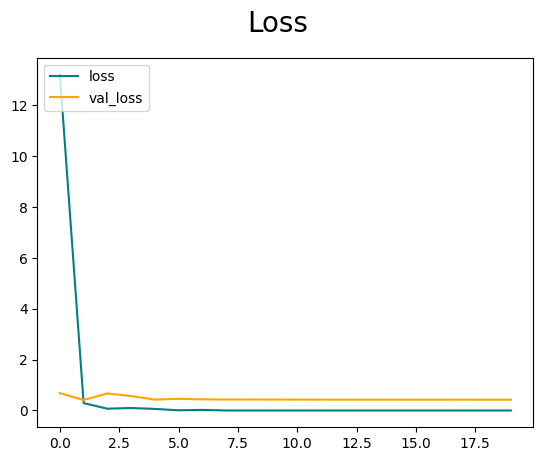

In [17]:
# Plot Performance
fig = plt.figure()
plt.plot(cnn.history['loss'],color='teal',label='loss')
plt.plot(cnn.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

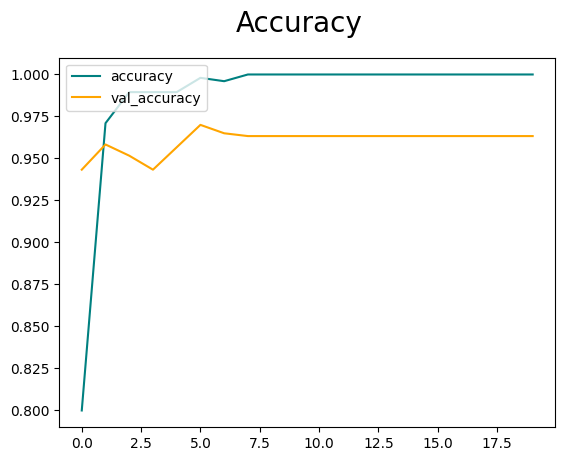

In [18]:
# Plot Performance
fig = plt.figure()
plt.plot(cnn.history['accuracy'],color='teal',label='accuracy')
plt.plot(cnn.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

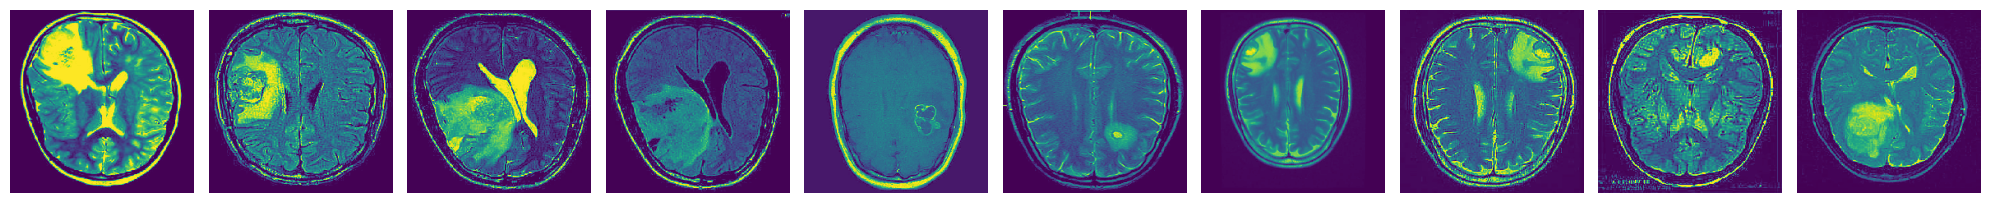

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
test_imgs,test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [20]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Make Predictions

In [21]:
predictions = model.predict(x=test_batches,verbose=0)

In [22]:
np.array(predictions)

array([[1.00000000e+00, 3.62238383e-30],
       [1.00000000e+00, 1.73191711e-22],
       [1.00000000e+00, 4.35889836e-34],
       [1.00000000e+00, 0.00000000e+00],
       [9.99914169e-01, 8.58824860e-05],
       [1.00000000e+00, 3.34947736e-09],
       [1.00000000e+00, 5.09701741e-28],
       [1.00000000e+00, 1.84525028e-20],
       [1.00000000e+00, 1.28228316e-37],
       [1.00000000e+00, 7.78180722e-37],
       [1.00000000e+00, 1.89341088e-34],
       [1.00000000e+00, 3.68661771e-32],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 7.06741949e-27],
       [1.00000000e+00, 9.48009201e-17],
       [1.00000000e+00, 2.84207810e-17],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.36910695e-24],
       [1.00000000e+00, 7.76709650e-37],
       [1.00000000e+00, 1.78840287e-35],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.000000

Plot the Confusion Matrix

In [23]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.class_indices

{'yes': 0, 'no': 1}

Confusion matrix, without normalization
[[193   7]
 [ 16 184]]


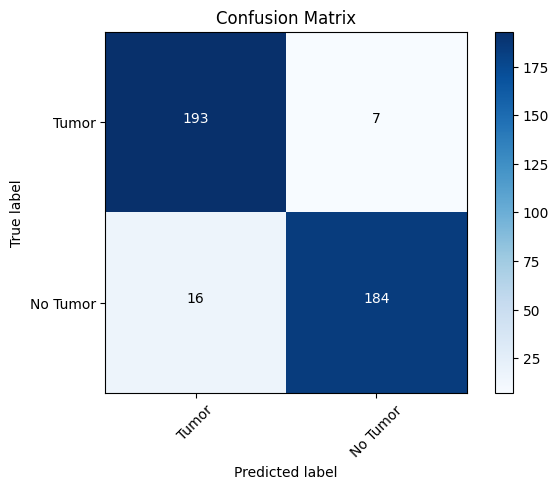

In [26]:
cm_plot_labels = ['Tumor','No Tumor']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')